This Notebook implements a complete stereo Visual Odometry pipeline (3D to 2D method) to elaborate the Part 1, Traverse 3, of the ESA's *Katwijk Beach Planetary Dataset* (available at the link https://robotics.estec.esa.int/datasets/katwijk-beach-11-2015/).

In the end the pipeline is tested using different combination of feature detector/descriptors and matcher for the disparity computation. The adopted error metrics are the one suggested by the KITTI leaderboard.

# Drive mount and dataset extraction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Select the path where you downloaded the Part1 dataset and unzip, example:
!unzip '/content/drive/MyDrive/Colab Notebooks/VO/Part1.zip'

# Packages initialization

In [3]:
import cv2
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import clear_output
from scipy.interpolate import interp1d, CubicSpline

# Ground truth
The ground truth was obtained using GPS localization data provided within the dataset.

In [4]:
from pyproj import Proj

# File paths
folder_path = 'Part1/'
gps_file_path = os.path.join(folder_path, 'gps-utm31.txt')
imu_file_path = os.path.join(folder_path, 'imu.txt')

# GPS data
gps_data = pd.read_csv(gps_file_path, sep=' ', header=None, names=[
    'timestamp', 'status', 'latitude', 'longitude', 'altitude', 'std_lat', 'std_lon', 'std_alt'])

# IMU data
imu_data = pd.read_csv(imu_file_path, sep=' ', header=None, names=[
    'timestamp', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z'])

# Convert timestamp in a readable format
gps_data['timestamp'] = pd.to_datetime(gps_data['timestamp'], format='%Y_%m_%d_%H_%M_%S_%f')
imu_data['timestamp'] = pd.to_datetime(imu_data['timestamp'], format='%Y_%m_%d_%H_%M_%S_%f')

# Syncronize timestamp
data = pd.merge_asof(gps_data.sort_values('timestamp'), imu_data.sort_values('timestamp'), on='timestamp')

# Transform GPS coordinates
proj_utm = Proj(proj='utm', zone=31, ellps='WGS84')
data['utm_x'], data['utm_y'] = proj_utm(data['longitude'].values, data['latitude'].values)
data['utm_z'] = data['altitude']
gps_pos = data[['utm_x', 'utm_y', 'utm_z']].values
gps_pos=gps_pos-gps_pos[0,:]

# Magnetometers data
mag_vec = data[['mag_x','mag_y','mag_z']].values

# Time interval between measurements
time_diff = (data['timestamp'].diff().dt.total_seconds().fillna(0)).values

Ground truth from GPS data only
Path length: 48.62163233085174


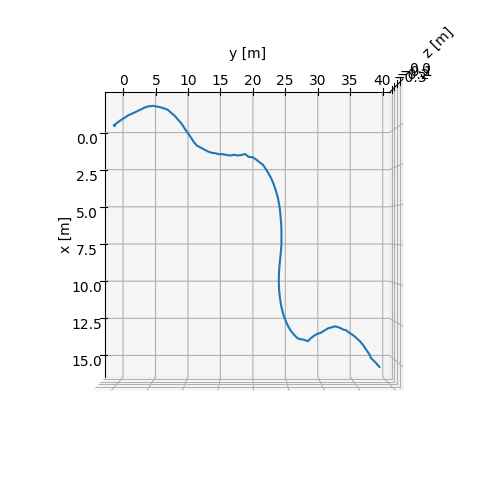

In [5]:
# PLOT OF THE GROUND TRUTH
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(gps_pos[:, 0],
        gps_pos[:, 1],
        gps_pos[:, 2], label='ground truth')

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

ax.view_init(elev=90, azim=0)
print('Ground truth from GPS data only')

num_points = 2000

path_indices = np.linspace(0, 1, num_points)
gps_indices = np.linspace(0, 1, len(gps_pos))

interp_func = interp1d(gps_indices, gps_pos, axis=0, kind='cubic')
interp_gt = interp_func(path_indices)
gt_2d = interp_gt[:, :2]

path_len = np.sum(np.linalg.norm(np.diff(gt_2d, axis=0), axis=1))
print('Path length:', path_len)

# Handler defintion and test
All stereocamera parameters are given in the dataset website.
In this cell we designed the **Cameraparams** and **Dataset_Handler** classes in order to simply manage the data.

In [6]:
# Object containing the parameters from the stereocameras
class Cameraparams():

  def __init__(self):
    import numpy as np

    # left intrinsic
    self.K_l = np.array([
    [8.342560029536488e+02, 0, 4.977146425239835e+02],
    [0, 8.389607387334217e+02, 3.987726521928708e+02],
    [0,0, 1.0]
                      ])
    # left distortion parameters
    self.dist_l = np.array([[-0.359945273497872, 0.169265715456672, 0, 0]])

    # right intrinsic
    self.K_r = np.array([
    [8.371285943173126e+02, 0, 4.819380406691490e+02],
    [0, 8.408162958028008e+02, 3.914599724721840e+02],
    [0,0, 1.0]
                      ])
    # right distortion parameters
    self.dist_r = np.array([[-0.353245255445656, 0.156612963967655, 0, 0]])

    # essential matrix
    self.E= np.array([
    [2.632498241837252e-04, -0.267736983024085, -0.263091412754095],
    [0.549791320916558, -0.252297455306530, 1.200775543946997e+02],
    [0.655794143163932,-1.200770044098519e+02, -0.254712375195772]])

    # relative rotation
    self.R=np.array([
    [1.0, 0.003280055174474, -0.003280055174474],
    [-0.003275110674652, 1.0, 0.003280055174474],
    [0.002344302325735,-0.002108428092670, 1.0]
                      ])
    # relative translation
    self.t=np.array([-1.200787783624933e+02, -0.262524983712090, 0.268292537673379])


camera=Cameraparams()

In [7]:
class Dataset_Handler():

    def __init__(self):
        import pandas as pd
        import os
        import cv2
        import numpy as np

# Create two time-ordered list of file names for left and right images
        self.path = 'Part1/LocCam/'
        self.all_img=os.listdir('Part1/LocCam/')

        self.images_left_file = []
        self.images_right_file = []
        self.images_left_x = []
        self.images_right_x = []

        # Itera attraverso tutti i file nella cartella di origine e divide L da R
        for filename in self.all_img:
          if filename.endswith('0.png'):
            self.images_left_x.append(filename)
          elif filename.endswith('1.png'):
            self.images_right_x.append(filename)

        # mette in ordine tutte le L e tutte le R
        self.images_left_file=sorted(self.images_left_x, key=lambda x: int(x.split("_")[5]*60 + x.split("_")[6]))
        self.images_right_file=sorted(self.images_right_x, key=lambda x: int(x.split("_")[5]*60 + x.split("_")[6]))
        self.num_frames = len(self.images_left_file)

# Extract first two pairs of images for handler testing
        self.reset_frames()
        # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread(self.path + self.images_left_file[0])
        self.first_image_right = cv2.imread(self.path + self.images_right_file[0])
        self.second_image_left = cv2.imread(self.path + self.images_left_file[1])
        self.second_image_right = cv2.imread(self.path + self.images_right_file[1])

        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]

        # Apply the rectification transformation
        self.first_image_left, self.first_image_right =self.my_rectification(self.first_image_left,self.first_image_right)
        self.second_image_left, self.second_image_right =self.my_rectification(self.second_image_left,self.second_image_right)

# Define a function to iterate trough the dataset
    def reset_frames(self):
       # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.path + name_left, 0)
                                     for name_left in self.images_left_file)
        self.images_right = (cv2.imread(self.path + name_right, 0)
                                     for name_right in self.images_right_file)

# Define a function to perform stereorectification and undistortion of images pairs
    def my_rectification(self,img_l,img_r):
        # Rectification and Undistortion part of the Handler
        # Load the camera calibration parameters
        mtx_l=camera.K_l
        dist_l=camera.dist_l
        mtx_r=camera.K_r
        dist_r=camera.dist_r

        # Relative position and orientation
        R = camera.R  # Rotation matrix between the cameras
        T = camera.t  # Translation vector between the cameras

        # Image size
        image_size = (self.imwidth, self.imheight)

        # Stereo rectification
        R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(mtx_l, dist_l, mtx_r, dist_r, image_size, R, T, alpha=-1)
        #alpha=0 means that the rectified images are zoomed and shifted so that only valid pixels are visible (no black areas after rectification).
        #alpha=1 means that the rectified image is decimated and shifted so that all the pixels from the original images from the cameras are

        # Compute the rectification transformation map
        left_map1, left_map2 = cv2.initUndistortRectifyMap(mtx_l, dist_r, R1, P1, image_size,  cv2.CV_16SC2)
        right_map1, right_map2 = cv2.initUndistortRectifyMap(mtx_r, dist_r, R2, P2, image_size,  cv2.CV_16SC2)

        # Apply the rectification transformation
        img_l2 = cv2.remap(img_l, left_map1, left_map2, cv2.INTER_LINEAR)
        img_r2 = cv2.remap(img_r, right_map1, right_map2, cv2.INTER_LINEAR)

        return img_l2, img_r2


handler=Dataset_Handler()

In [8]:
###### TEST ######
handler.reset_frames()

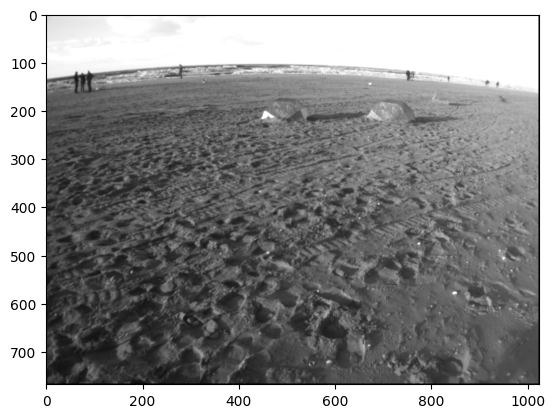

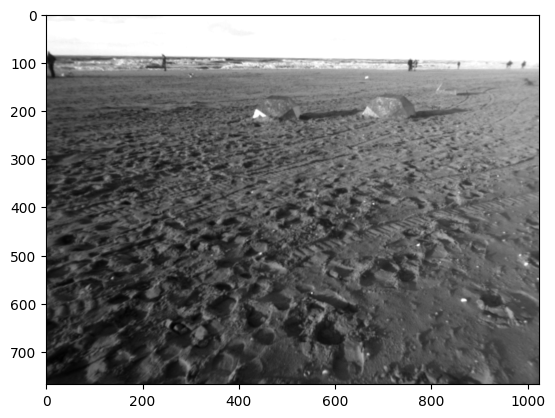

In [9]:
###### TEST ######
image_left_plus1 = next(handler.images_left)
image_right_plus1 = next(handler.images_right)
image_left, image_right = handler.my_rectification(image_left_plus1,image_right_plus1)

plt.figure()
plt.imshow(image_left_plus1,'gray')
plt.figure()
plt.imshow(image_left,'gray')

# Disparity

In [10]:
def compute_disparity(img_left, img_right, matcher='bm', rgb=True, verbose=False):

    '''
    INPUT:
    L-R image pair
    matcher can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb (bool) set to True if RGB images
    verbose (bool) set to True to report time to compute disparity map
    '''

    # Matching parameters, obtained by trial and error
    bin = 5
    num_disparities = bin*16
    block_size = 13
    block_size_bm = 11
    matcher_name = matcher

    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size_bm
                                     )

    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * block_size ** 2,  # smoothness parameter
                                        P2 = 32 * 3 * block_size ** 2, # smoothness parameter
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()

    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)

    return disp_left

Time to compute disparity map using StereoSGBM: 0:00:00.212762
Time to compute disparity map using StereoBM: 0:00:00.067769


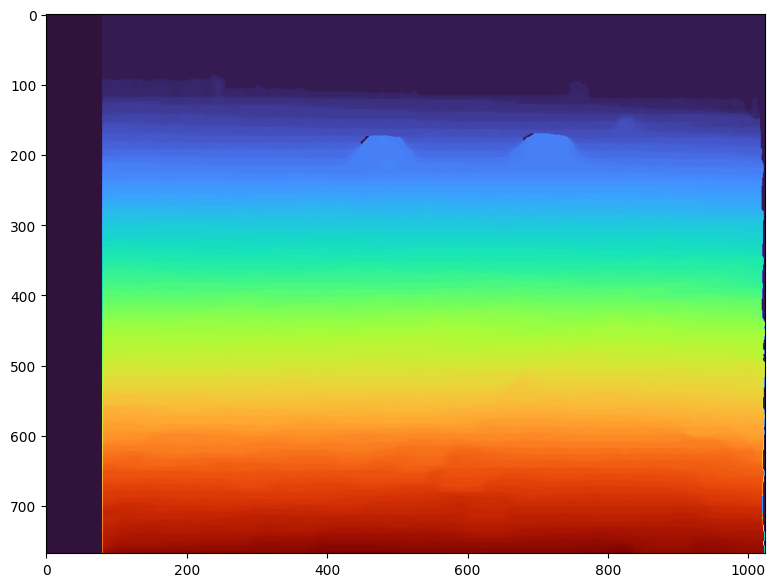

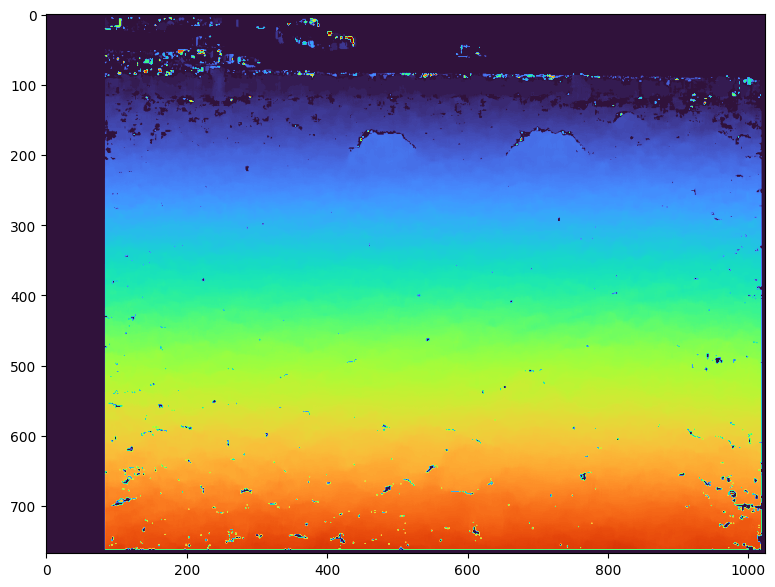

In [11]:
###### TEST ######
%matplotlib inline

disp = compute_disparity(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp,'turbo');

disp = compute_disparity(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp,'turbo');

# Depth

In [12]:
def compute_depth(disp_left):
    '''
    INPUT:
    disparity map
    '''
    k_left=camera.K_l

    # Get focal length of x axis for left camera
    f = k_left[0][0]

    # Calculate baseline of stereo pair
    b=np.abs(camera.t[0])

    # Avoid instability and division by zero
    disp_left[disp_left <= 0] = 0.1

    # Make depth map
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left

    return depth_map

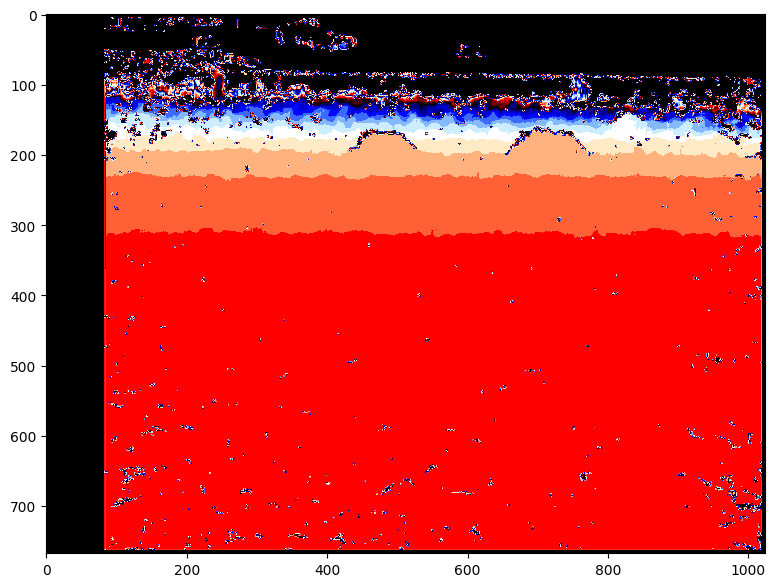

In [13]:
###### TEST ######
depth = compute_depth(disp)
plt.figure(figsize=(11,7))
plt.imshow(depth,'flag');

1001764.44

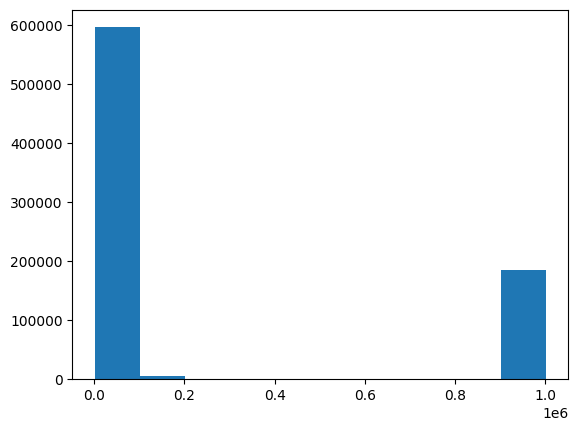

In [14]:
# Evaluate depth map to understand validity treshold
plt.hist(depth.flatten());
depth.max()
# in our case this value is 0.2e6

i vale:  84


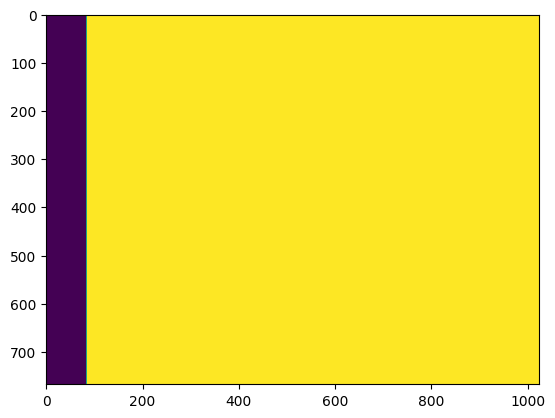

In [15]:
# Create mask to reduce the search area to the valid one
for i, pixel in enumerate(depth[700]):
    if pixel < depth.max():
        mask_idx=i
        break
print('i vale: ', i)
enumerate(depth[4])
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (mask_idx,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

# Extracting and Matching features

In [16]:
def extract_features(image, detector='sift', mask=None):
    '''
    INPUT:
    image
    detector can be 'sift', 'orb', 'fast' or 'brisk'
    mask can be None or a mask map of the search area
    '''
    if detector == 'sift':
        det = cv2.SIFT_create()
        kp, des = det.detectAndCompute(image, mask)
    elif detector == 'orb':
        det = cv2.ORB_create()
        kp, des = det.detectAndCompute(image, mask)
    elif detector == 'fast':
        det = cv2.SIFT_create()
        fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
        kp = fast.detect(image, None)
        kp, des = det.compute(image, kp)
    elif detector == 'brisk':
        det = cv2.BRISK_create()
        kp, des = det.detectAndCompute(image, mask)

    return kp, des

def match_features(des1, des2, detector='sift', sort=True, k=2):
    '''
    INPUT:
    des1, des2: feature descriptors
    detector can be 'sift', 'orb', 'fast' or 'brisk'
    sort (bool) set to True to sort matches by distance
    k (int) number of matches to return
    '''
    if detector == 'sift':
        matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
    elif detector == 'orb':
        matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
    elif detector == 'brisk':
        matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
    elif detector == 'fast':
        matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)

    # Match features

    matches = matcher.knnMatch(des1, des2, k=k)

    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

def filter_matches_distance(matches, dist_threshold):
    '''
    INPUT:
    matches
    dist_threshold: to filter matches with ratio test
    '''
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

def visualize_matches(image1, kp1, image2, kp2, match):
    '''
    INPUT:
    image1, image2
    kp1, kp2 keypoints detected in image1 and image2
    match: matches foud between the two images
    '''
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Number of matches before filtering: 500
Number of matches after filtering: 342


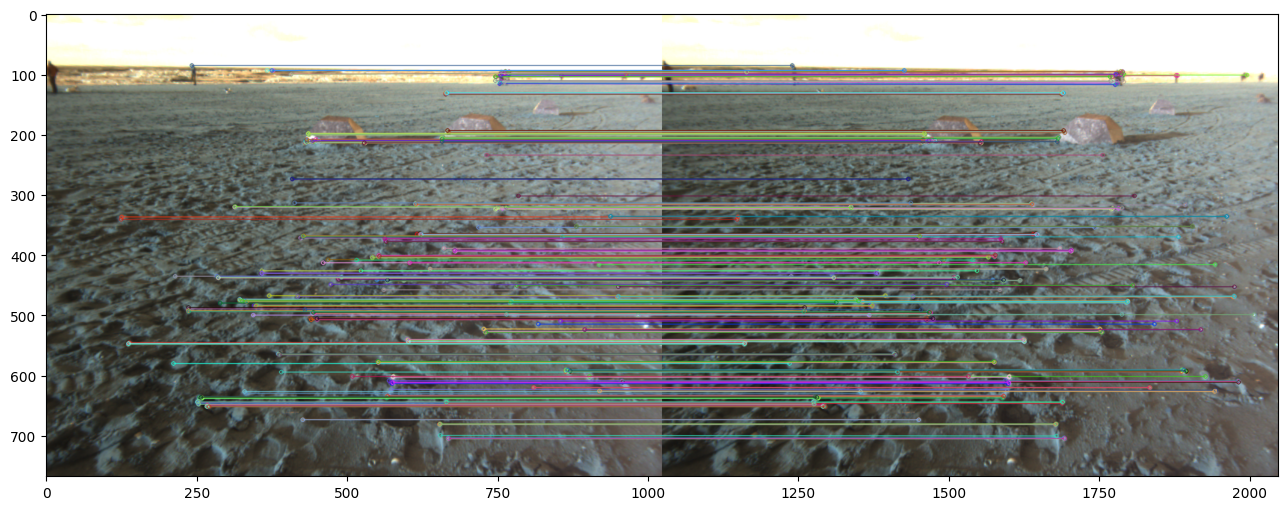

In [17]:
###### TEST ######
image_left = handler.first_image_left
image_plus1 = handler.second_image_left

kp0, des0 = extract_features(image_left, 'orb',mask=mask)
kp1, des1 = extract_features(image_plus1, 'orb',mask=mask)
matches = match_features(des0, des1, detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.75)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

# Estimate Motion
Estimating relative rotation and translation between subsequent stereo pairs using 3D-to-2D method.

In [18]:
def estimate_motion(match, kp1, kp2, k, depth=None, max_depth=0.2e6):
    """
    Estimate camera motion from a pair of subsequent image frames

    INPUT:
    match: list of matched features from the pair of images
    kp1, kp2: keypoints in the first and second image
    k: camera intrinsic matrix
    depth: Depth map of the first frame
    max_depth: depth threshold. 0.2e6 is default

    OUTPUT:
    rmat: 3x3 rotation matrix
    tvec: 3x1 translation vector
    image1_points: matched feature pixel coordinates in the first image.
    image2_points: matched feature pixel coordinates in the second image.
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))

    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])


    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    object_points = np.zeros((0, 3))
    delete = []

    # Extract depth information
    for i, (u, v) in enumerate(image1_points):
        z = depth[int(v), int(u)]
        # If the depth is above 0.2e6, then remove this keypoint
        if z > max_depth:
            delete.append(i)
            continue

        # Use arithmetic to extract x and y (faster than using inverse of k)
        x = z*(u-cx)/fx
        y = z*(v-cy)/fy
        object_points = np.vstack([object_points, np.array([x, y, z])])

    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)

    # Use PnP algorithm with RANSAC
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)

    rmat = cv2.Rodrigues(rvec)[0]


    return rmat, tvec, image1_points, image2_points

# Visual Odometry

In [19]:
def visual_odometry(handler, detector='sift', filter_match_distance=None,
                    stereo_matcher='bm', mask=None, subset=None, skip=0):
    '''
    INPUT:
    handler: Dataset Handler object
    detector: can be 'sift' or 'orb'. Default is 'sift'.
    filter_match_distance: value for ratio test on matched features.
    stereo_matcher: can be 'bm' or 'sgbm'.
    mask: mask to reduce feature search area to where depth information available.
    subset: number of frames to compute. Defaults to None to compute all frames.
    skip: number of frames to skip to speedup process. Default to 0 to compute all frames

    OUTPUT:
    trajectory: Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    '''

    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        num_frames = handler.num_frames


    # Initialize transformation matrix. First pose is identity
    T_tot = np.eye(4)
    R_tot = np.eye(3)
    #x0=np.array([0,0,0]).T
    #path=x0.T

    # initialize trajectory
    trajectory = np.zeros((((num_frames-1)//(skip+1))+1, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth

    # Get intrinsic k matrix
    k_left=camera.K_l

    handler.reset_frames()
    image_left_plus1 = next(handler.images_left)
    image_right_plus1 = next(handler.images_right)

    # Iterate through frames
    for i in range((num_frames - 1)//(skip+1)):
        start = datetime.datetime.now()

        # Get stereo images for depth estimation
        image_left = image_left_plus1
        image_right = image_right_plus1
        image_left, image_right = handler.my_rectification(image_left,image_right)

        # Skip to the chosen next frame according to the skip parameter
        for boh in range(skip):
          image_left_plus1c = next(handler.images_left)
          image_right_plus1c = next(handler.images_right)

        image_left_plus1 = next(handler.images_left)
        image_right_plus1 = next(handler.images_right)
        image_plus1, image_not_used = handler.my_rectification(image_left_plus1,image_right_plus1)

        # Estimate depth
        disp = compute_disparity(image_left, image_right, matcher=stereo_matcher,rgb=False, verbose=False)
        depth = compute_depth(disp)

        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)

        # Get matches
        matches_unfilt = match_features(des0,
                                        des1,
                                        detector=detector,
                                        sort=True)

        # Filter matches
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt

        # Estimate motion
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)

        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T

        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        R_tot = R_tot @ rmat.T
        #x0=x0 + np.dot(R_tot,-tvec)

        #path=np.vstack([path,x0.T])


        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]

        # End the timer for the frame and report frame rate
        end = datetime.datetime.now()
        clear_output(wait=True)
        print('Time to compute frame {}:'.format(i+1), end-start)


    return trajectory

In [20]:
from scipy.spatial.transform import Rotation as Rxyz
from scipy.interpolate import interp1d, CubicSpline

def frame_allignement(trajectory):
  tilt=27*np.pi/180  # 27 deg downwards tilt angle of the LocCam

  R = np.array([
      [0, 1, 0],
      [np.sin(tilt), 0, -np.cos(tilt)],
      [-np.cos(tilt), 0, -np.sin(tilt)]])

  rotz= Rxyz.from_euler('z', 72.5, degrees=True).as_matrix() # in plane angular displacement from GPS frame
  R= R @ rotz
  path = np.array(trajectory[:,:,3])

  path_new=[]
  for line in path:
    path_new.append(np.dot(R.T,line))

  path_new=np.array(path_new)

  return path_new


def traj_interp(trajectory, gps_pos):
  num_points = len(trajectory)

  path_indices = np.linspace(0, 1, num_points)
  gps_indices = np.linspace(0, 1, len(gps_pos))

  interp_func = interp1d(gps_indices, gps_pos, axis=0, kind='cubic')
  new_gt = interp_func(path_indices)
  return new_gt

# Performance Evaluation
Thr chosen indexes of merit to evaluate VO performances are the one proposed and used in the KITTI leaderboard (link). In particular, using the ground-truth trajectory and the estimated one, the following parameters are computed:
*   Geometric distance history (m)
*   Angular difference history (deg)
*   RMSE relative to path length (%)
*   Mean angular difference relative to path length (deg/m)
*   Average time to compute one step of VO (s)



In [21]:
def evaluate_VO(path_xy, gt_xy, path_len):
  #Compute geometric distance history:
  dist_history_temp = np.linalg.norm(path_xy - gt_xy, axis=1)
  dist_history = dist_history_temp[11:]

  # Compute orientation difference history
  delta = np.diff(path_xy[::1,:], axis=0)
  delta_gt = np.diff(gt_xy[::1,:], axis=0)

  theta_path = np.arctan2(delta[:, 1], delta[:, 0])
  theta_gt = np.arctan2(delta_gt[:, 1], delta_gt[:, 0])

  delta_theta = np.abs(theta_gt - theta_path)*180/np.pi
  delta_theta[delta_theta > 90] = 0 # filtering because initially the rover is still

  # Compute RMSE relative to path length:
  rmse = np.sqrt(np.mean(dist_history_temp**2))
  rmse_p = (rmse/path_len)*100

  # Compute mean angular difference relative to path length:
  mean_ang_diff = np.mean(delta_theta)/path_len

  return path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse

# TESTS
Hereafter different tests of the Stereo-VO pipeline are carried out. The objective was to always reproduce the performances of a system working in real time. So, when considering different feature detector/descriptors and matchers, it was necessary to tune the *skip* parameter in order to account the fact that the software is not able to elaborate all the captured images yielding an overall time which is approximatively under 5 minutes (T := overall duration of the transfer).

The *skip*  paramter can be directly linked to a fictitious image acquistion frequency, which would be the one corresponding to continous real time operation of the navigation software.


**Example:**

If *skip=0*  then all images are used so the acquisition frequency is *f = numframes/T = 3.74 Hz*, and the software frequency must be higher than this value to work in real time.

If *skip=3*  then *f=1.05 Hz* which makes the constraint above easier to fullfil.

# TEST 1: ORB + BM

In [22]:
###### TEST 1 ######
subset=None
skip = 1 # 1.87 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='orb',stereo_matcher='bm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 562: 0:00:00.260341
Time to compute Visual Odometry:  0:03:07.357143
Mean time to compute one step:  0.3333756992882562


In [23]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  3.357718821732335
RMSE relative to path length (%):  6.905812620366864
Mean angular difference relative to path length (deg/m):  0.2308339240528585


Text(0, 0.5, 'Error [m]')

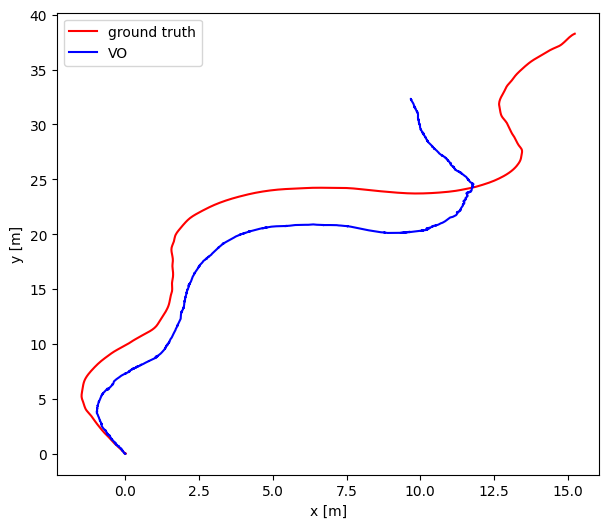

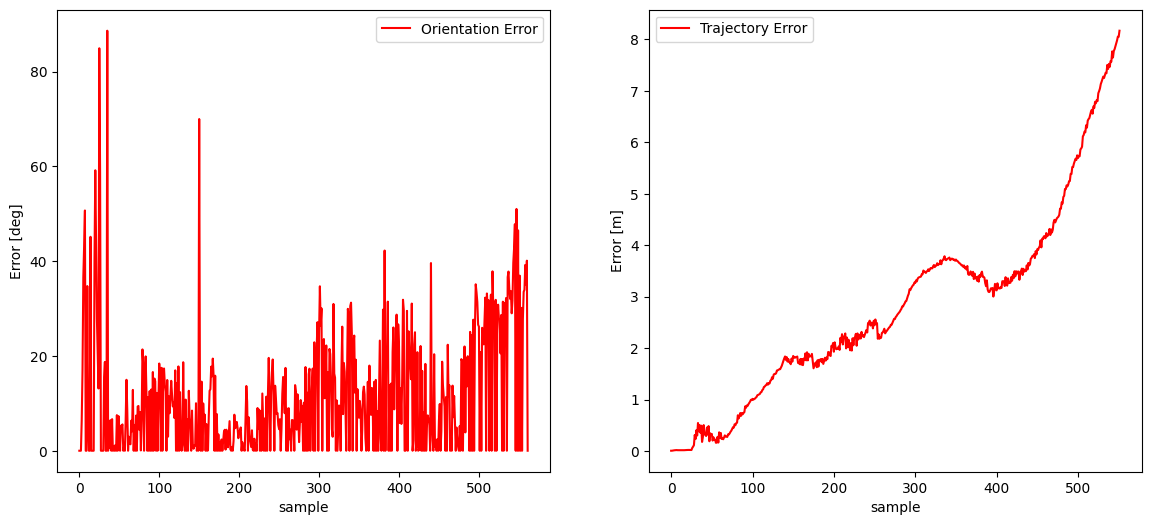

In [24]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST 2: ORB + SGBM

In [25]:
###### TEST 2 ######
subset=None
skip = 1 # 1.87 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='orb',stereo_matcher='sgbm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 562: 0:00:00.586197
Time to compute Visual Odometry:  0:04:14.037900
Mean time to compute one step:  0.45202473309608543


In [26]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  2.3047213222754395
RMSE relative to path length (%):  4.740115071811424
Mean angular difference relative to path length (deg/m):  0.21396501350255526


Text(0, 0.5, 'Error [m]')

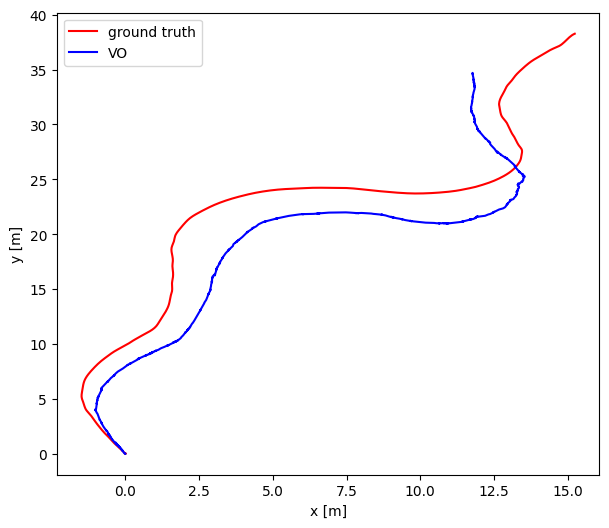

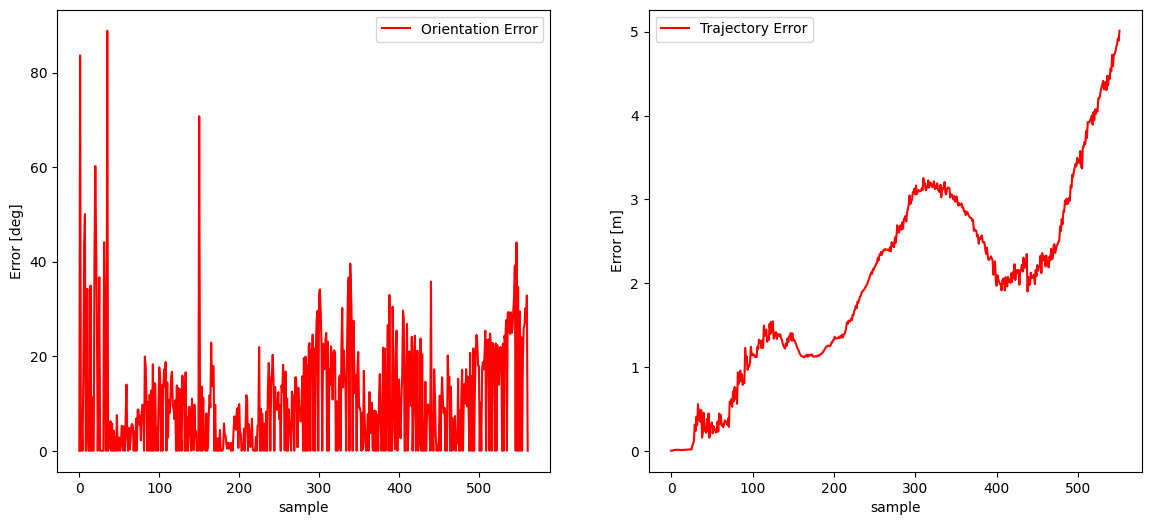

In [27]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST 3: FAST + BM

In [28]:
###### TEST 3 ######
subset=None
skip = 3 # 1.05 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='fast',stereo_matcher='bm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 281: 0:00:00.838160
Time to compute Visual Odometry:  0:04:50.045700
Mean time to compute one step:  1.032191103202847


In [29]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  3.280038476011971
RMSE relative to path length (%):  6.746047631006205
Mean angular difference relative to path length (deg/m):  0.1882144878631444


Text(0, 0.5, 'Error [m]')

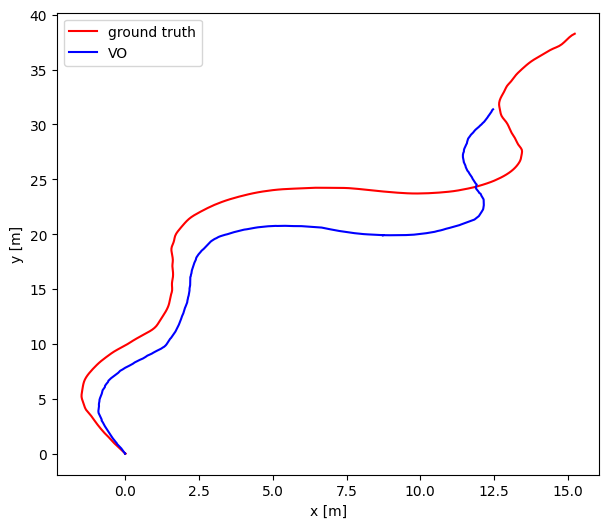

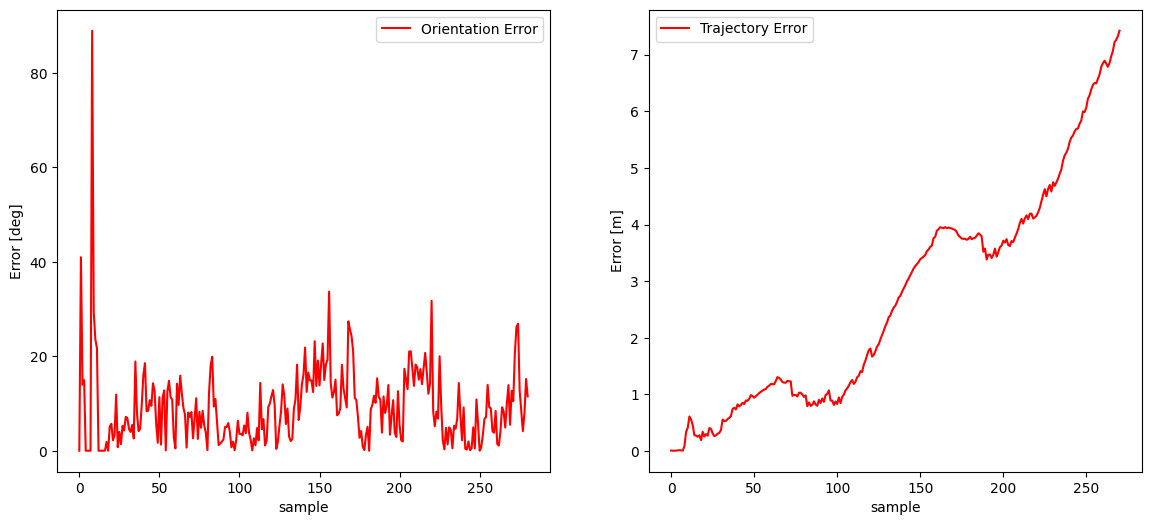

In [30]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST 4: FAST + SGBM

In [22]:
###### TEST 4 ######
subset=None
skip = 4 # 0.75 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='fast',stereo_matcher='sgbm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 224: 0:00:01.525798
Time to compute Visual Odometry:  0:05:00.549499
Mean time to compute one step:  1.3417388348214287


In [23]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  0.8092690514451795
RMSE relative to path length (%):  1.664421807022872
Mean angular difference relative to path length (deg/m):  0.18272907413791836


Text(0, 0.5, 'Error [m]')

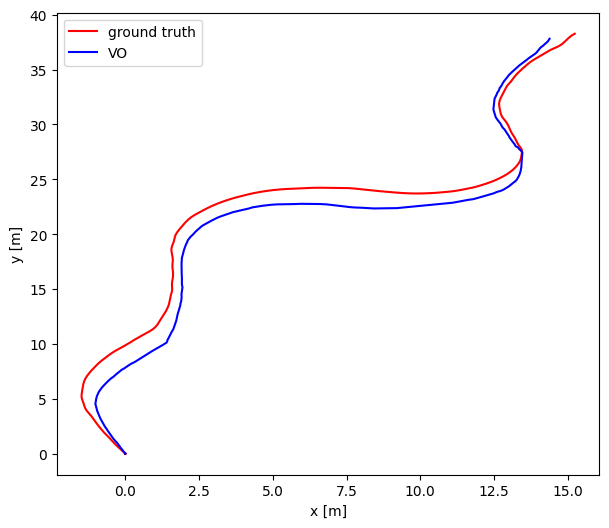

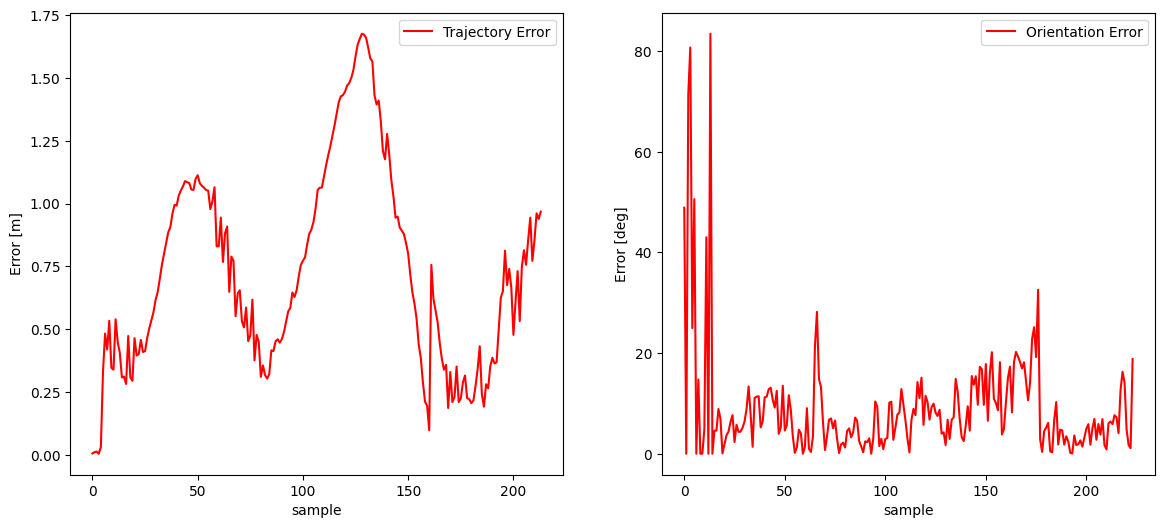

In [26]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST 5: BRISK + BM

In [34]:
###### TEST 5 ######
subset=None
skip = 4 # 0.75 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='brisk',stereo_matcher='bm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 224: 0:00:00.842700
Time to compute Visual Odometry:  0:03:51.501299
Mean time to compute one step:  1.0334879419642857


In [35]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  2.9848927574768367
RMSE relative to path length (%):  6.139022106797599
Mean angular difference relative to path length (deg/m):  0.15704453054730982


Text(0, 0.5, 'Error [m]')

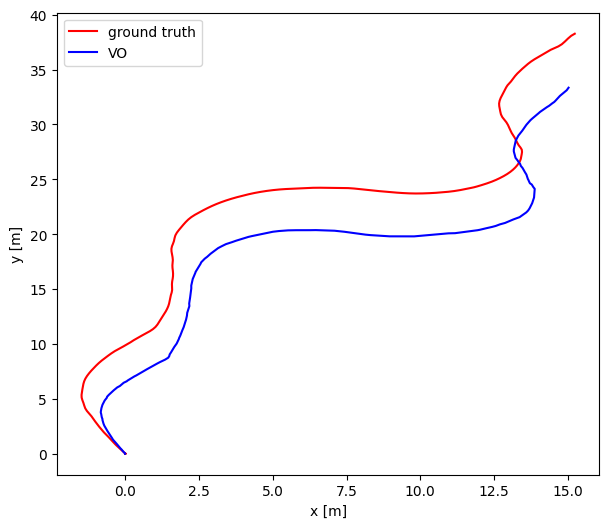

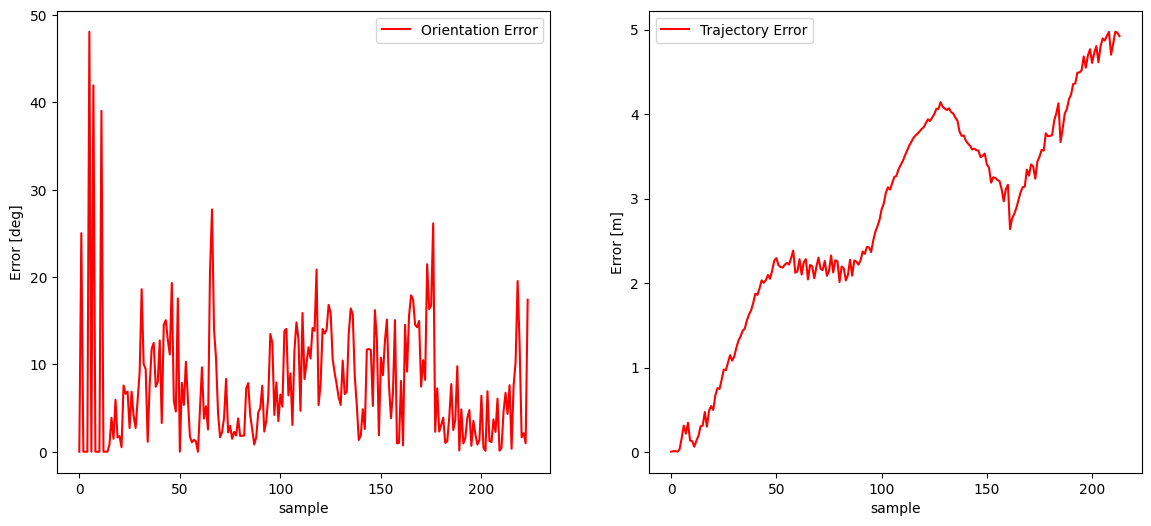

In [36]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST 6: BRISK + SGBM

In [37]:
###### TEST 6 ######
subset=None
skip = 4 # 0.75 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='brisk',stereo_matcher='sgbm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 224: 0:00:00.926163
Time to compute Visual Odometry:  0:04:29.411727
Mean time to compute one step:  1.2027309241071429


In [38]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  1.0527340219752501
RMSE relative to path length (%):  2.1651556550216062
Mean angular difference relative to path length (deg/m):  0.17590537445867047


Text(0, 0.5, 'Error [m]')

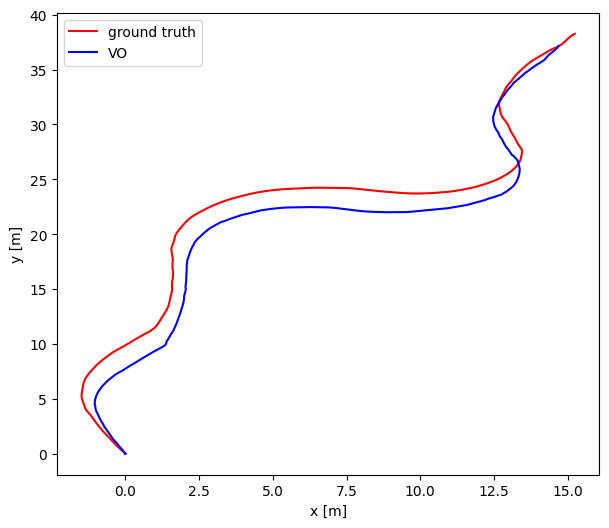

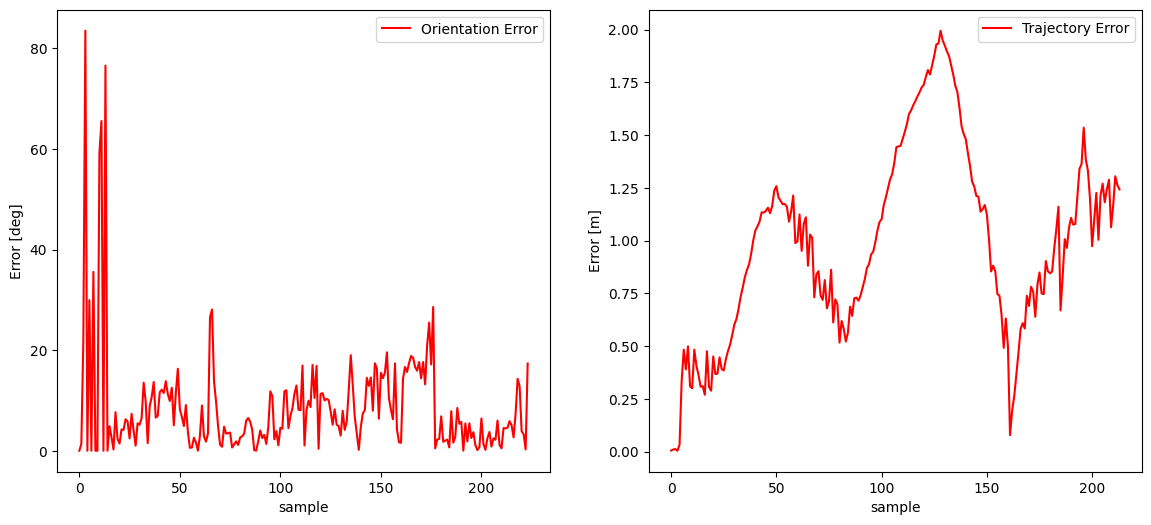

In [39]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST 7: SIFT + BM

In [40]:
###### TEST 7 ######
subset=None
skip = 9 # 0.37 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='sift',stereo_matcher='bm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 112: 0:00:02.028561
Time to compute Visual Odometry:  0:04:59.871555
Mean time to compute one step:  2.677424598214286


In [41]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  4.271043183326786
RMSE relative to path length (%):  8.784244745762463
Mean angular difference relative to path length (deg/m):  0.17264832885151662


Text(0, 0.5, 'Error [m]')

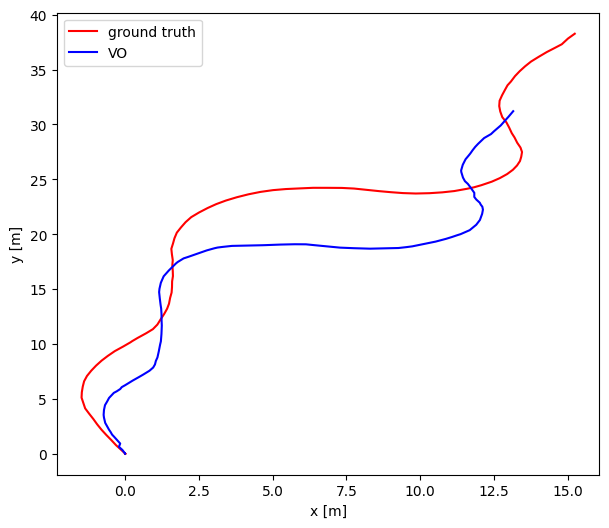

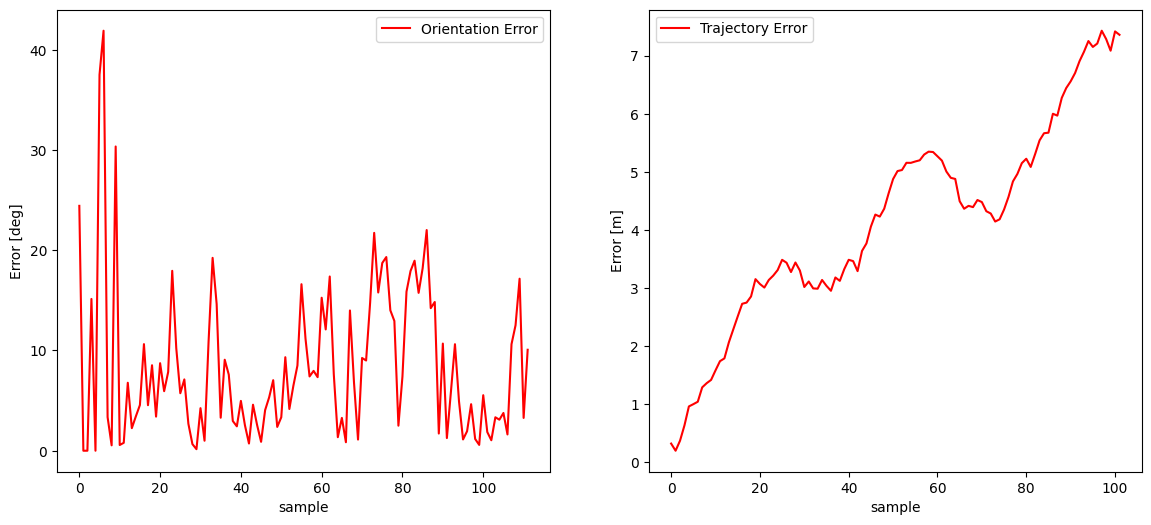

In [42]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST 8: SIFT + SGBM

In [43]:
###### TEST 8 ######
subset=None
skip = 10 # 0.34 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='sift',stereo_matcher='sgbm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 102: 0:00:02.224428
Time to compute Visual Odometry:  0:04:51.824168
Mean time to compute one step:  2.8610212549019605


In [44]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  1.7022994827713265
RMSE relative to path length (%):  3.5011154524550414
Mean angular difference relative to path length (deg/m):  0.16976804802182704


Text(0, 0.5, 'Error [m]')

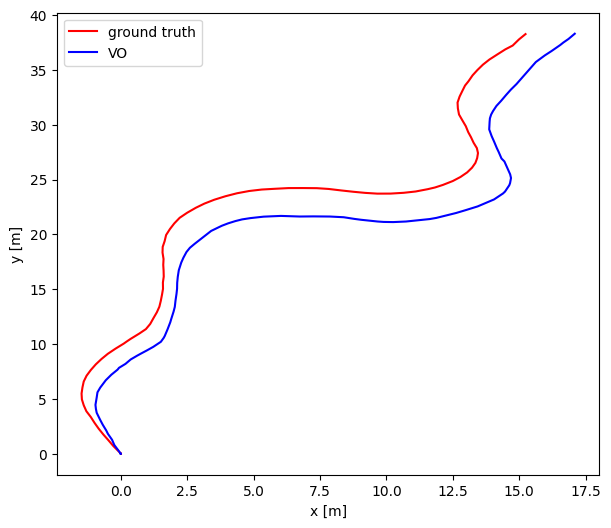

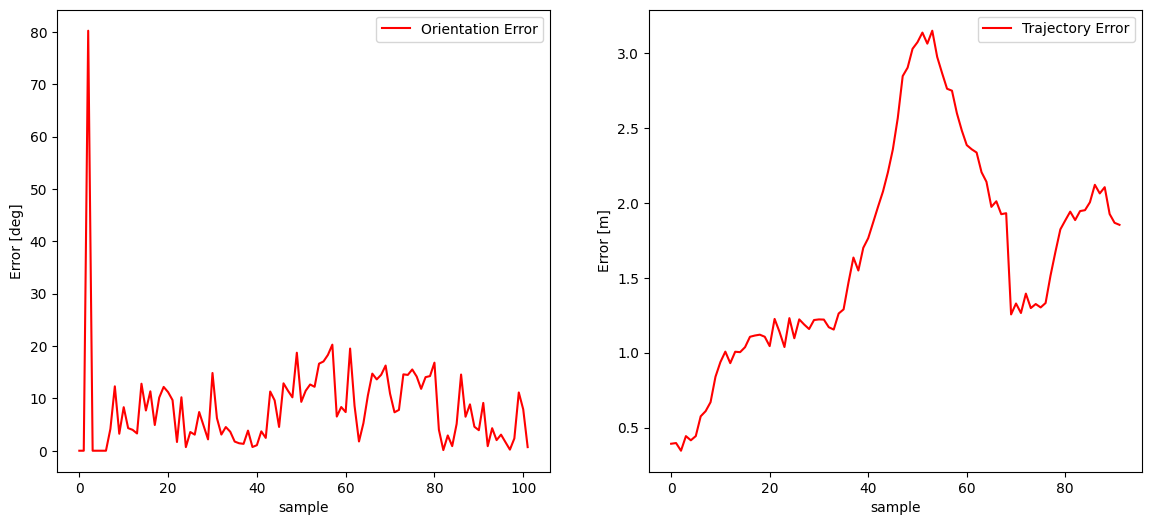

In [45]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')

# TEST bonus: SIFT + SGBM no real-time

In [27]:
###### TEST bonus ######
subset=None
skip = 5 # 0.62 Hz

start = datetime.datetime.now()
trajectory = visual_odometry(handler,filter_match_distance=0.75, detector='sift',stereo_matcher='sgbm', mask=None,  subset=subset, skip=skip)
end = datetime.datetime.now()

print('Time to compute Visual Odometry: ', end-start)
fram = (handler.num_frames - 1)//(skip+1)
print('Mean time to compute one step: ', (end-start).total_seconds()/fram)

Time to compute frame 187: 0:00:03.234530
Time to compute Visual Odometry:  0:08:59.491973
Mean time to compute one step:  2.884983812834225


In [28]:
# Align estimation with gt
path_new = frame_allignement(trajectory)
new_gt = traj_interp(path_new, gps_pos)
path_xy = path_new[:, :2]/1000 # convert in m
gt_xy = new_gt[:, :2]

# Evaluate results
path_len, dist_history, delta_theta, rmse_p, mean_ang_diff, rmse = evaluate_VO(path_xy, gt_xy, path_len)
print('Path Length (m): ', path_len)
print('RMSE (m): ', rmse)
print('RMSE relative to path length (%): ', rmse_p)
print('Mean angular difference relative to path length (deg/m): ', mean_ang_diff)

Path Length (m):  48.62163233085174
RMSE (m):  0.7245481330294912
RMSE relative to path length (%):  1.4901764879040185
Mean angular difference relative to path length (deg/m):  0.16447578214478947


Text(0, 0.5, 'Error [m]')

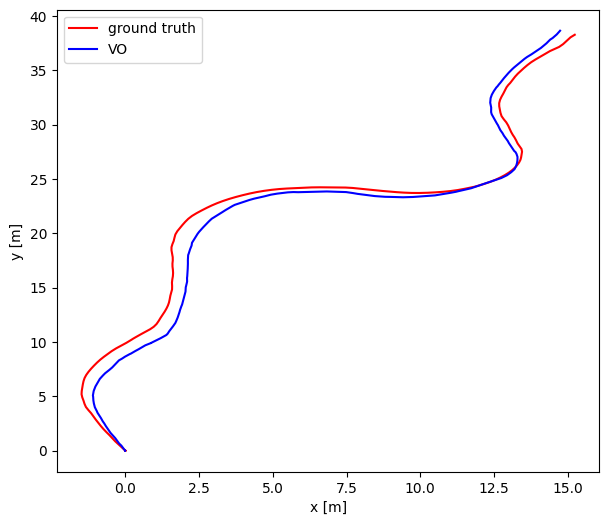

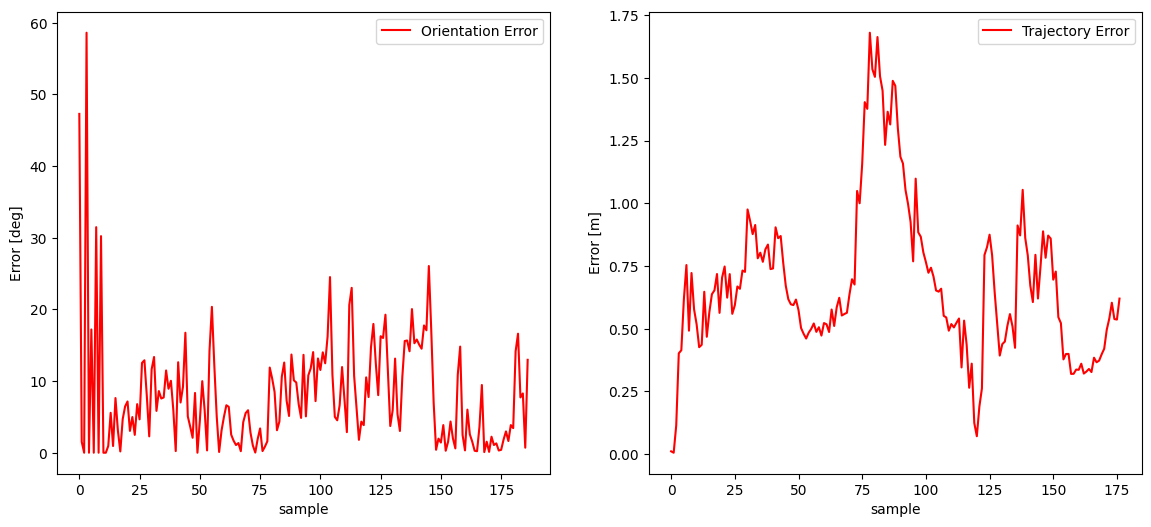

In [29]:
%matplotlib inline

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)

ax.plot(new_gt[:, 0],
        new_gt[:, 1], label='ground truth',color='red')

ax.plot(path_new[:, 0]/1000,
        path_new[:, 1]/1000, label='VO',color='blue')

ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(delta_theta, label='Orientation Error',color='red')

ax1.legend()
ax1.set_xlabel('sample')
ax1.set_ylabel('Error [deg]')

#plot 2
ax2.plot(dist_history, label='Trajectory Error',color='red')

ax2.legend()
ax2.set_xlabel('sample')
ax2.set_ylabel('Error [m]')